# Disciple - 取引シミュレーション（Jupyter用）

In [3]:
import datetime
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import get_trend_footer, load_setting
from funcs.tide import get_date_dir_from_file, get_date_str_from_file_2
from funcs.tse import get_ticker_name_list
from modules.disciple import Disciple
from structs.res import AppRes

In [16]:
debug = False

res = AppRes()
excel = "ticks_20260203.xlsx"
# code = "285A"
# code = "4689"
# code = "7011"
# code = "7203"
# code = "8306"
code = "8410"
# code = "9984"

dict_ts = dict()
dict_ts["datetime_str_2"] = get_date_str_from_file_2(excel)
dict_setting = load_setting(res, code)
title_str = get_trend_footer(dict_ts, dict_setting)

date_str = get_date_dir_from_file(excel)
print(date_str)

if debug:
    output_dir = os.path.join("tmp", date_str)
else:
    output_dir = os.path.join(res.dir_output, date_str)
print(output_dir)
os.makedirs(output_dir, exist_ok=True)

app = Disciple(excel, code, dict_setting)
app.run()

2026/02/03
output/2026/02/03
パラメータ
PERIOD_WARMUP : 30
PERIOD_MA_1 : 30
PERIOD_MA_2 : 600
LOSSCUT_1 : -5.0
N_MINUS_MAX : 180
DD_PROFIT : 50.0
DD_RATIO : 0.8


In [17]:
# Matplotlib の共通設定
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

In [18]:
# テクニカル指標
print("テクニカル指標")
df_tech = app.getTechnicals()
print(df_tech)

テクニカル指標
                               ts  price   volume        vwap         ma1  \
2026-02-03 09:00:04  1.770077e+09  299.3   203300  299.300000  299.300000   
2026-02-03 09:00:06  1.770077e+09  298.7   210600  298.700000  299.000000   
2026-02-03 09:00:08  1.770077e+09  298.7   210600  298.700000  298.900000   
2026-02-03 09:00:10  1.770077e+09  298.4   211800  298.657647  298.775000   
2026-02-03 09:00:12  1.770077e+09  298.4   211800  298.657647  298.700000   
...                           ...    ...      ...         ...         ...   
2026-02-03 15:24:40  1.770100e+09  298.8  3613800  299.800859  298.903333   
2026-02-03 15:24:42  1.770100e+09  298.8  3613800  299.800859  298.893333   
2026-02-03 15:24:44  1.770100e+09  298.8  3613800  299.800859  298.883333   
2026-02-03 15:24:46  1.770100e+09  298.8  3613800  299.800859  298.880000   
2026-02-03 15:24:48  1.770100e+09  298.8  3613800  299.800859  298.873333   

                            ma2  cross1  profit  profit_max  drawdo

# of cross: 52
output/2026/02/03/8410_trend_technical.png


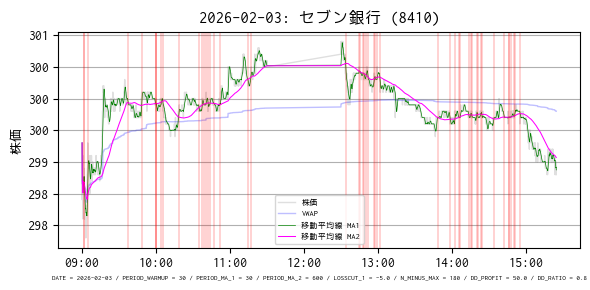

In [19]:
n = 1

if n == 1:
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.grid(axis="y")
else:
    fig = plt.figure(figsize=(6, 8))
    ax = dict()
    gs = fig.add_gridspec(
        n,
        1,
        wspace=0.0,
        hspace=0.0,
        height_ratios=[2 if i == 0 else 1 for i in range(n)],
    )
    for i, axis in enumerate(gs.subplots(sharex="col")):
        ax[i] = axis
        ax[i].grid(axis="y")

name = get_ticker_name_list([code])[code]
ax.set_title(f"{dict_ts['datetime_str_2']}: {name} ({code})")
ax.plot(df_tech["price"], linewidth=1, color="gray", alpha=0.25, label="株価")
ax.plot(df_tech["vwap"], linewidth=1, color="blue", alpha=0.25, label="VWAP")
ax.plot(df_tech["ma1"], linewidth=0.5, color="green", label="移動平均線 MA1")
ax.plot(df_tech["ma2"], linewidth=0.75, color="magenta", label="移動平均線 MA2")
ax.set_xlabel(title_str, fontsize=5)
ax.set_ylabel("株価")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.legend(fontsize=6)

list_cross = df_tech[df_tech["cross1"] != 0].index
print(f"# of cross: {len(list_cross)}")
for t in list_cross:
    ax.axvline(x=t, color="red", linestyle="solid", linewidth=0.25)

# plt.suptitle(title_str, fontsize=5)
plt.tight_layout()
# plt.subplots_adjust(top=0.89)
output = os.path.join(output_dir, f"{code}_trend_technical.png")
print(output)
plt.savefig(output)
plt.show()